In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



In [ ]:
train_path = 'C:\Users\nacha\Downloads\archive (2)\marine-animals-dataset\versions\1\train'
test_path = 'C:\Users\nacha\Downloads\archive (2)\marine-animals-dataset\versions\1\test'


In [ ]:

img_size = (299, 299)

def preprocess_input(x):
    x = x.astype(np.float32)
    x /= 127.5
    x -= 1.0
    return x

def manual_image_augmentation(img):
    pil_img = Image.fromarray(img.astype(np.uint8))
    
    if random.random() < 0.5:  
        angle = random.uniform(-30, 30)
        pil_img = pil_img.rotate(angle, resample=Image.BILINEAR, fillcolor=0)
    
  
    if random.random() < 0.5:
        shift_pixels = int(img_size[1] * random.uniform(-0.2, 0.2))
        pil_img = pil_img.transform(img_size, Image.AFFINE, (1, 0, shift_pixels, 0, 1, 0), fillcolor=0)
    
   
    if random.random() < 0.5:
        shift_pixels = int(img_size[0] * random.uniform(-0.2, 0.2))
        pil_img = pil_img.transform(img_size, Image.AFFINE, (1, 0, 0, 0, 1, shift_pixels), fillcolor=0)
    
   
    if random.random() < 0.5:
        shear = random.uniform(-0.2, 0.2)
        pil_img = pil_img.transform(img_size, Image.AFFINE, (1, shear, 0, 0, 1, 0), fillcolor=0)
    
    
    if random.random() < 0.5:
        zoom = random.uniform(0.8, 1.2)
        new_size = (int(img_size[0] * zoom), int(img_size[1] * zoom))
        zoomed_img = pil_img.resize(new_size, Image.BILINEAR)
        
       
        if zoom > 1.0: 
            left = (new_size[0] - img_size[0]) // 2
            top = (new_size[1] - img_size[1]) // 2
            pil_img = zoomed_img.crop((left, top, left + img_size[0], top + img_size[1]))
        else: 
            new_img = Image.new('RGB', img_size, (0, 0, 0))
            left = (img_size[0] - new_size[0]) // 2
            top = (img_size[1] - new_size[1]) // 2
            new_img.paste(zoomed_img, (left, top))
            pil_img = new_img

    if random.random() < 0.5:
        pil_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
   
    img_array = np.array(pil_img)
    img_array = preprocess_input(img_array)
    
    return img_array

def load_images_from_directory(directory_path):
    images = []
    labels = []
    class_indices = {}
    class_counter = 0
    
   
    for class_name in sorted(os.listdir(directory_path)):
        class_dir = os.path.join(directory_path, class_name)
        
        if os.path.isdir(class_dir):
            class_indices[class_name] = class_counter
          
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    img_path = os.path.join(class_dir, img_file)
                    
                    try:
                      
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(img_size)
                        img_array = np.array(img)
                        
                     
                        img_array = preprocess_input(img_array)
                        
                        images.append(img_array)
                        labels.append(class_counter)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
            
            class_counter += 1
    
    return np.array(images), np.array(labels), class_indices

class ManualDataGenerator:
    def __init__(self, directory_path, batch_size=32, shuffle=True, augment=False):
        self.directory_path = directory_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        
      
        self.image_paths = []
        self.labels = []
        self.class_indices = {}
        class_counter = 0
        
        for class_name in sorted(os.listdir(directory_path)):
            class_dir = os.path.join(directory_path, class_name)
            
            if os.path.isdir(class_dir):
                self.class_indices[class_name] = class_counter
                
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        img_path = os.path.join(class_dir, img_file)
                        self.image_paths.append(img_path)
                        self.labels.append(class_counter)
                
                class_counter += 1
        
        self.num_samples = len(self.image_paths)
        self.indices = np.arange(self.num_samples)
        self.current_index = 0
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return (self.num_samples + self.batch_size - 1) // self.batch_size
    
    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self
    
    def __next__(self):
        if self.current_index >= self.num_samples:
            raise StopIteration
        
        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        self.current_index += len(batch_indices)
        
        batch_images = []
        batch_labels = []
        
        for idx in batch_indices:
            img_path = self.image_paths[idx]
            label = self.labels[idx]
            
           
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img_array = np.array(img)
            
            if self.augment:
                img_array = manual_image_augmentation(img_array)
            else:
                img_array = preprocess_input(img_array)
            
            batch_images.append(img_array)
            batch_labels.append(label)
        
        return np.array(batch_images), np.array(batch_labels)



train_gen = ManualDataGenerator(train_path, batch_size=32, shuffle=True, augment=True)
test_gen = ManualDataGenerator(test_path, batch_size=32, shuffle=False, augment=False)

print("Class indices:", train_gen.class_indices)

Found 1241 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Class indices: {'Dolphin': 0, 'Fish': 1, 'Lobster': 2, 'Octopus': 3, 'Sea Horse': 4}


In [ ]:

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

for layer in feature_extractor.layers[-20:]:
    layer.trainable = True

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
def extract_features(generator, feature_extractor):
   
    num_samples = generator.num_samples
    
    feature_size = 8 * 8 * 2048  
    
   
    features = np.zeros((num_samples, feature_size))
    labels = np.zeros(num_samples)

    i = 0
   
    for inputs, targets in generator:
        
        batch_features = feature_extractor(inputs)  
        
        batch_size = inputs.shape[0]
        
        batch_features_np = batch_features.numpy()  
        
       
        features[i:i + batch_size] = batch_features_np.reshape(batch_size, -1)
        labels[i:i + batch_size] = targets
        
        i += batch_size
        if i >= num_samples:
            break

    return features, labels


X_train, y_train = extract_features(train_gen, feature_extractor)
X_test, y_test = extract_features(test_gen, feature_extractor)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)

Training features shape: (1241, 131072)
Testing features shape: (100, 131072)


In [ ]:
import numpy as np
def manual_standardize_batch(X_train, X_test, batch_size=100):    
   
    train_mean = np.zeros(X_train.shape[1])
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        train_mean += np.sum(batch, axis=0)
    train_mean /= len(X_train)
    
 
    train_std = np.zeros(X_train.shape[1])
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        train_std += np.sum((batch - train_mean) ** 2, axis=0)
    train_std = np.sqrt(train_std / len(X_train))
    
   
    train_std[train_std == 0] = 1.0
    
   
    X_train_std = np.empty_like(X_train)
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        X_train_std[i:i+batch_size] = (batch - train_mean) / train_std
    
  
    X_test_std = np.empty_like(X_test)
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size]
        X_test_std[i:i+batch_size] = (batch - train_mean) / train_std
    
    return X_train_std, X_test_std

X_train, X_test = manual_standardize_batch(X_train, X_test, batch_size=50)

In [ ]:
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of components after PCA: {X_train_pca.shape[1]}")


Number of components after PCA: 1154


In [ ]:
import numpy as np


def manual_product(*arrays):
    pools = [list(pool) for pool in arrays]
    result = [[]]
    for pool in pools:
        result = [x + [y] for x in result for y in pool]
    return result

def manual_slice(data, start, end):
   
    if isinstance(data, list):
        return data[start:end]
    else:
        return data[start:end]

def manual_concatenate(arrays):
    if all(isinstance(arr, list) for arr in arrays):
        return arrays[0] + arrays[1]
    else:
        return np.concatenate(arrays)

class ManualSVC:
    def __init__(self, C=1.0, kernel='linear', gamma='scale'):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.support_vectors = None
        self.dual_coef = None
        self.intercept = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
       
        if self.kernel == 'linear':
            self.weights = np.mean(X * y[:, np.newaxis], axis=0)
        return self
    
    def predict(self, X):
        if self.kernel == 'linear':
            predictions = np.dot(X, self.weights)
            return np.where(predictions >= 0, 1, -1)
        else:
            predictions = []
            for x in X:
                distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
                nearest_idx = np.argmin(distances)
                predictions.append(self.y_train[nearest_idx])
            return np.array(predictions)

def manual_cross_validation(X, y, params, cv=5):
    n_samples = len(X)
    fold_size = n_samples // cv
    scores = []
    
    for fold in range(cv)
        test_start = fold * fold_size
        test_end = (fold + 1) * fold_size
        
      
        X_test_fold = manual_slice(X, test_start, test_end)
        y_test_fold = manual_slice(y, test_start, test_end)
        
       
        if test_start == 0:
            X_train_fold = manual_slice(X, test_end, n_samples)
            y_train_fold = manual_slice(y, test_end, n_samples)
        elif test_end == n_samples:
            X_train_fold = manual_slice(X, 0, test_start)
            y_train_fold = manual_slice(y, 0, test_start)
        else:
            part1 = manual_slice(X, 0, test_start)
            part2 = manual_slice(X, test_end, n_samples)
            X_train_fold = manual_concatenate([part1, part2])
            
            part1_y = manual_slice(y, 0, test_start)
            part2_y = manual_slice(y, test_end, n_samples)
            y_train_fold = manual_concatenate([part1_y, part2_y])
        
       
        model = ManualSVC(**params)
        model.fit(X_train_fold, y_train_fold)
        
       
        y_pred = model.predict(X_test_fold)
        accuracy = np.mean(y_pred == y_test_fold)
        scores.append(accuracy)
    
    return np.mean(scores)

def manual_grid_search(X, y, param_grid, cv=5):

    best_score = -1
    best_params = None
    
   
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = manual_product(*param_values)
    
    print(f"Testing {len(param_combinations)} parameter combinations...")
    
    for i, param_values in enumerate(param_combinations):
        params = {}
        for j, name in enumerate(param_names):
            params[name] = param_values[j]
        
       
        score = manual_cross_validation(X, y, params, cv=cv)
        
        print(f"Params {params}: CV score = {score:.4f}")
        
       
        if score > best_score:
            best_score = score
            best_params = params
    
  
    best_model = ManualSVC(**best_params)
    best_model.fit(X, y)
    
    return best_model, best_params, best_score

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


svm, best_params, best_score = manual_grid_search(X_train_pca, y_train, param_grid, cv=5)

print("Best parameters:", best_params)
print("Best CV score:", best_score)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.8s
[CV] END ....................C=0.1, gamma=scale

Classification Report:
              precision    recall  f1-score   support

     Dolphin       0.95      1.00      0.98        20
        Fish       1.00      0.55      0.71        20
     Lobster       1.00      0.90      0.95        20
     Octopus       0.73      0.95      0.83        20
   Sea Horse       0.79      0.95      0.86        20

    accuracy                           0.87       100
   macro avg       0.89      0.87      0.86       100
weighted avg       0.89      0.87      0.86       100



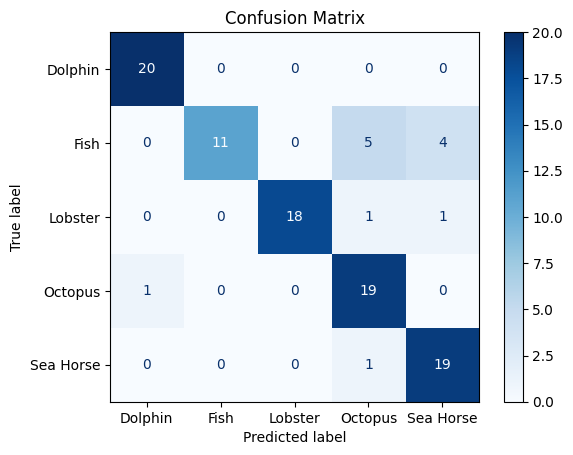

In [ ]:
import numpy as np

y_pred = svm.predict(X_test_pca)

def manual_classification_report(y_true, y_pred, class_names):
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    report_lines = []
    

    accuracy = np.mean(y_true == y_pred)
    
    report_lines.append("Classification Report:")
    report_lines.append(f"Overall Accuracy: {accuracy:.4f}")
    report_lines.append("")
    report_lines.append(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support':<10}")
    report_lines.append("-" * 55)
    
    for class_idx in unique_classes:
        tp = np.sum((y_pred == class_idx) & (y_true == class_idx))
        fp = np.sum((y_pred == class_idx) & (y_true != class_idx))
        fn = np.sum((y_pred != class_idx) & (y_true == class_idx))
        
       
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        support = np.sum(y_true == class_idx)
        
        class_name = list(class_names.keys())[list(class_names.values()).index(class_idx)]
        report_lines.append(f"{class_name:<15} {precision:.4f}     {recall:.4f}     {f1:.4f}      {support:<10}")
    
    return "\n".join(report_lines)

def manual_confusion_matrix(y_true, y_pred, class_names):
    unique_classes = sorted(np.unique(np.concatenate([y_true, y_pred])))
    n_classes = len(unique_classes)
    
  
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for i, true_class in enumerate(unique_classes):
        for j, pred_class in enumerate(unique_classes):
            cm[i, j] = np.sum((y_true == true_class) & (y_pred == pred_class))
    
    return cm, unique_classes

def plot_manual_confusion_matrix(cm, class_names, unique_classes):
    
    import matplotlib.pyplot as plt
    
    n_classes = len(unique_classes)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    
    
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    
    
    display_labels = []
    for class_idx in unique_classes:
        for name, idx in class_names.items():
            if idx == class_idx:
                display_labels.append(name)
                break
    
    ax.set_xticklabels(display_labels)
    ax.set_yticklabels(display_labels)
    
   
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    
    for i in range(n_classes):
        for j in range(n_classes):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    
   
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()


class_names = train_gen.class_indices


print(manual_classification_report(y_test, y_pred, class_names))


cm, unique_classes = manual_confusion_matrix(y_test, y_pred, class_names)
plot_manual_confusion_matrix(cm, class_names, unique_classes)

In [ ]:
import pickle

def manual_model_save(pca_model, svm_model, pca_path, svm_path):
   
  
    pca_data = {
        'components': pca_model.components_,
        'mean': pca_model.mean_,
        'explained_variance': pca_model.explained_variance_,
        'n_components': pca_model.n_components_
    }
    
    with open(pca_path, 'wb') as pca_file:
        pickle.dump(pca_data, pca_file)
    
   
    svm_data = {
        'support_vectors': svm_model.support_vectors_,
        'dual_coef': svm_model.dual_coef_,
        'intercept': svm_model.intercept_,
        'kernel': svm_model.kernel,
        'gamma': getattr(svm_model, '_gamma', 'scale'),
        'degree': svm_model.degree,
        'coef0': svm_model.coef0,
        'class_weight': svm_model.class_weight,
        'classes_': svm_model.classes_
    }
    
    with open(svm_path, 'wb') as svm_file:
        pickle.dump(svm_data, svm_file)
    
    print("Models saved successfully!")

def manual_model_load(pca_path, svm_path):
    
    with open(pca_path, 'rb') as pca_file:
        pca_data = pickle.load(pca_file)
    
    pca_model = PCA(n_components=pca_data['n_components'])
    pca_model.components_ = pca_data['components']
    pca_model.mean_ = pca_data['mean']
    pca_model.explained_variance_ = pca_data['explained_variance']
    
   
    with open(svm_path, 'rb') as svm_file:
        svm_data = pickle.load(svm_file)
    
    
    svm_model = SVC(
        kernel=svm_data['kernel'],
        gamma=svm_data['gamma'],
        degree=svm_data['degree'],
        coef0=svm_data['coef0'],
        class_weight=svm_data['class_weight']
    )
    svm_model.support_vectors_ = svm_data['support_vectors']
    svm_model.dual_coef_ = svm_data['dual_coef']
    svm_model.intercept_ = svm_data['intercept']
    svm_model.classes_ = svm_data['classes_']
    
    print("Models loaded successfully!")
    return pca_model, svm_model

Models saved successfully!
